In [19]:
# State space: (x, x_dot, theta, theta_dot)
import numpy as np
import scipy.linalg as la
import control as ct

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Dynamics model

In [20]:
# State vector: (x, theta, x_dot, theta_dot)

def cartpend_update(t, q, F, params):
    """cart-pendulum ODE
    """
    
    # Get the parameters for the model
    M = params.get('M')
    m = params.get('m')
    J = params.get('J')
    c = params.get('c')
    ell = params.get('ell')
    gamma = params.get('gamma')
    g = params.get('g')

    x = q[0]
    theta = q[1]
    xdot = q[2]
    thetadot = q[3]
    
    # Solve for second derivative by solving matrix equation
    M = np.array([[M+m, -m*ell*np.cos(theta)],
                  [-m*ell*np.cos(theta), J+m*ell**2]])
    C_1 = -(c*xdot + m*ell*np.sin(theta)*thetadot**2) + F
    C_2 = -(gamma*thetadot-m*g*ell*np.sin(theta))
    ddq = np.matmul(la.inv(M), np.array([C_1,C_2],dtype=object))
    
#     print('Timestep: ',t, '    Input force: ', F)

    # placeholder for derivative of state vector
    dq = np.zeros(4)
    dq[0] = xdot
    dq[1] = thetadot
    dq[2] = ddq[0]
    dq[3] = ddq[1]
    return dq

def cartpend_output(t, q, u, params):
    # return x and theta
    y = np.array([q[0],q[1]])
    return y

In [32]:
# Default vehicle parameters (including nominal velocity)
cartpend_params={'M' : 10.,
                'm' : 80.,
                'J' : 100.,
                'c' : 0.1,
                'ell' : 1.,
                'gamma' : 0.01,
                'g' : 9.8}

# Define the cart pendulum dynamics as an input/output system
cart_pend = ct.NonlinearIOSystem(
    cartpend_update, cartpend_output, states=4, name='cartpend', params=cartpend_params, inputs=('f'), outputs=('x', 'theta'), )

## Open Loop Simulation

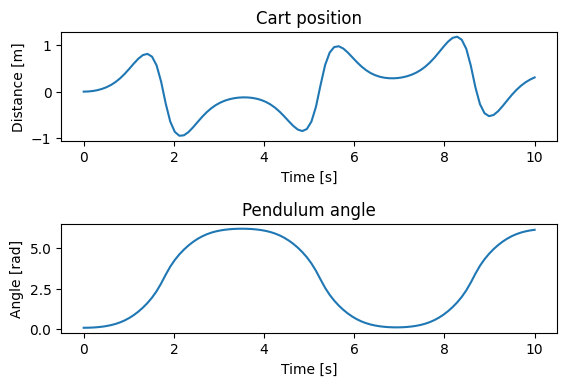

In [35]:
# Run simulation for tf seconds
tf = 10.  
t = np.linspace(0, tf, 100)

# Initial conditions
theta0 = 0.1
x0 = 0.
IC = np.array([x0, theta0, 0, 0.])  # Initial condition

# Step input
f = np.ones_like(t)

# parameters to control the precision of the scipy ivp_solver
solver_params={'rtol':1e-4, 'atol':1e-5}

time, outputs = ct.input_output_response(cart_pend, t, U=f, X0=IC, solve_ivp_kwargs=solver_params)

# Plot the data
fig, axs = plt.subplots(2,1)

# plot the cart position
axs[0].plot(time,outputs[0])
# plot the pendulum angle
axs[1].plot(time,outputs[1])

# Format the plot
axs[0].set_title("Cart position")
axs[0].set_ylabel('Distance [m]')
axs[0].set_xlabel('Time [s]')

axs[1].set_title("Pendulum angle")
axs[1].set_ylabel('Angle [rad]')
axs[1].set_xlabel('Time [s]')

axs[0].set_position([0.125, 0.75, 0.775, 0.227])
axs[1].set_position([0.125, 0.35, 0.775, 0.227])

## Linearize system at the equlibrium point (pendulum upright position)

In [39]:
# Create the desired trajectory 
Ud = 0.
Xd = np.array([0.,0.,0.,0.])

# Now linizearize the system around this trajectory
linsys = cart_pend.linearize(0, Ud, Xd)

In [40]:
linsys

<LinearIOSystem:sys[2]:['u[0]']->['y[0]', 'y[1]']>